# PLAS Benchmark Evaluation



In [19]:
mode = "quick"
# mode = "big"

In [20]:
import json
import os
from typing import Callable
import numpy as np
def traverse_and_aggregate(log, keys_to_aggregate: list[str], aggregation_functions: dict[str, Callable], ignore_keys: list[str] = []):
    collected_values = {key: [] for key in keys_to_aggregate}

    def recursive_traverse(d):
        nonlocal collected_values
        if isinstance(d, dict):
            for k, v in d.items():
                if k in ignore_keys:
                    continue
                for key in keys_to_aggregate:
                    if key in k:
                        collected_values[key].append(v)
                recursive_traverse(v)
        elif isinstance(d, list):
            for item in d:
                recursive_traverse(item)

    recursive_traverse(log)
    
    aggregates = {key: aggregation_functions[key](collected_values[key]) for key in collected_values.keys()}

    return aggregates


def aggregate_benchmark_logs(metric: str, ignore_keys: list[str] = []):
    plot_data = {"duration": [], "metric": [], "version": []}
    for file in os.listdir(f"measurements/{mode}"):
        if file.endswith(".json"):
            benchmark_log = json.load(open(f"measurements/{mode}/{file}"))
            aggregates = traverse_and_aggregate(benchmark_log, ["duration", metric], {"duration": sum, metric: np.mean}, ignore_keys)
            plot_data["duration"].append(aggregates["duration"])
            plot_data["metric"].append(aggregates[metric])
            plot_data["version"].append(benchmark_log["version"])
    return plot_data


def plot_pareto_front(duration: list[float], metric: list[float], version: list[str], metric_label: str):
    # Find Pareto Front Indeces
    pareto_front = []
    for i in range(len(duration)):
        dominated = False
        for j in range(len(duration)):
            di, dj = duration[i], duration[j]
            ci, cj = metric[i], metric[j]
            if (dj < di and cj >= ci) or (dj <= di and cj > ci):
                dominated = True
                break
        if not dominated:
            pareto_front.append(i)

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    # Plot all points
    import numpy as np
    for i in range(len(duration)):
        plt.scatter(duration[i], metric[i], color='green' if i in pareto_front else 'red', label=f"{i + 1}   {version[i]}")
        # Add version label as text annotation slightly above and to the right
        plt.annotate(str(i + 1), 
                    (duration[i], metric[i]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=8)

    # Draw green lines between points on the pareto front in Manhattan distance manner
    pareto_points = sorted(
        [(duration[i], metric[i]) for i in pareto_front], key=lambda x: x[0]
    )
    pareto_x, pareto_y = zip(*pareto_points)

    for i in range(len(pareto_x) - 1):
        x0, y0 = pareto_x[i], pareto_y[i]
        x1, y1 = pareto_x[i + 1], pareto_y[i + 1]
        # Draw horizontal line
        if i == 0:
            plt.plot([x0, x1], [y0, y0], color='green', linestyle='--', alpha=0.5, label="Pareto Front")
        else:
            plt.plot([x0, x1], [y0, y0], color='green', linestyle='--', alpha=0.5)
        # Draw vertical line  
        plt.plot([x1, x1], [y0, y1], color='green', linestyle='--', alpha=0.5)

    plt.xlabel('Total Runtime (s)')
    plt.ylabel(f"Avg. {metric_label}")
    plt.title(f'{mode}bench - {metric_label} vs Runtime')
    plt.legend()

    plt.show()


## Pareto Fronts

### Compression Factor vs Runtime


#### All (3DGS + Images + Random Data)


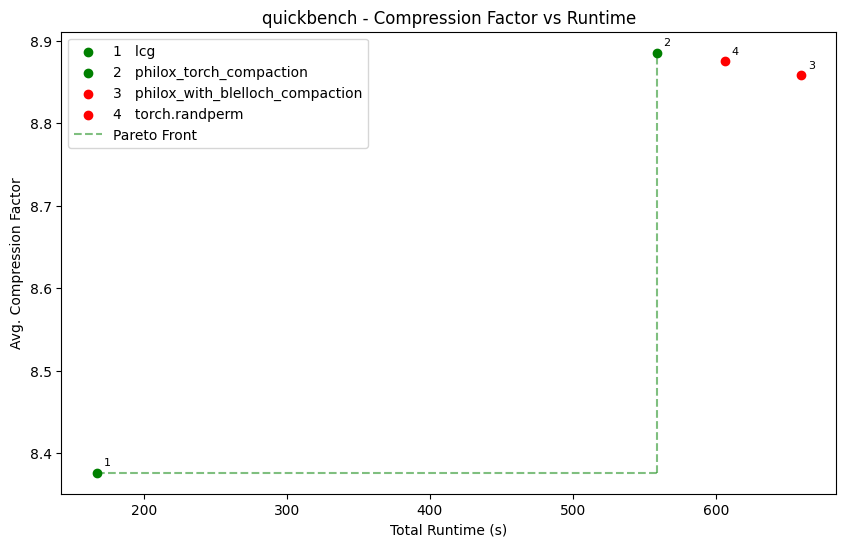

In [21]:
plot_pareto_front(**aggregate_benchmark_logs("compression_factor"), metric_label="Compression Factor")

#### 3DGS

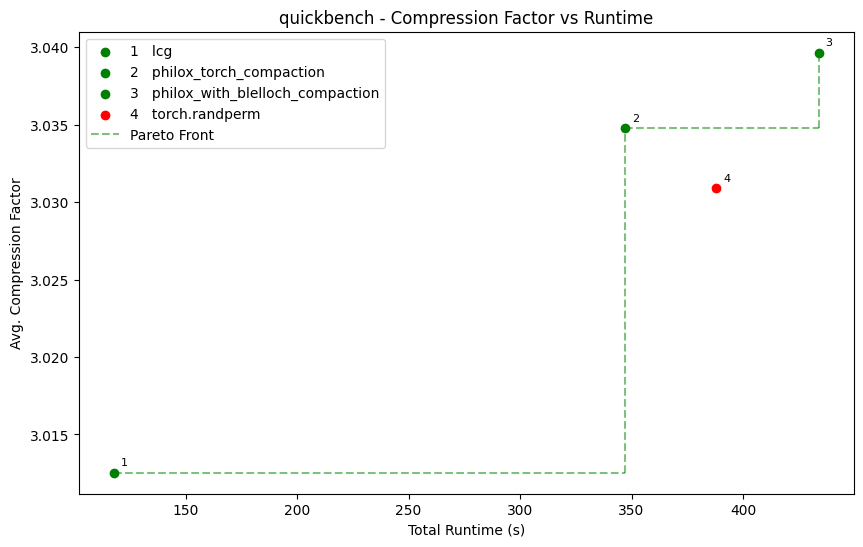

In [22]:
plot_pareto_front(**aggregate_benchmark_logs("compression_factor", ignore_keys=["images", "random_data"]), metric_label="Compression Factor")

#### Images

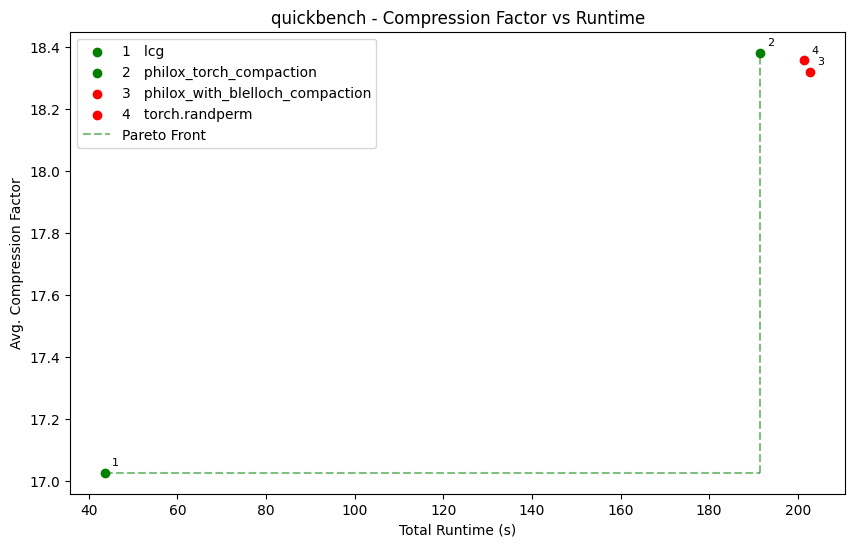

In [23]:
plot_pareto_front(**aggregate_benchmark_logs("compression_factor", ignore_keys=["gaussian_splatting", "random_data"]), metric_label="Compression Factor")

#### Random Data

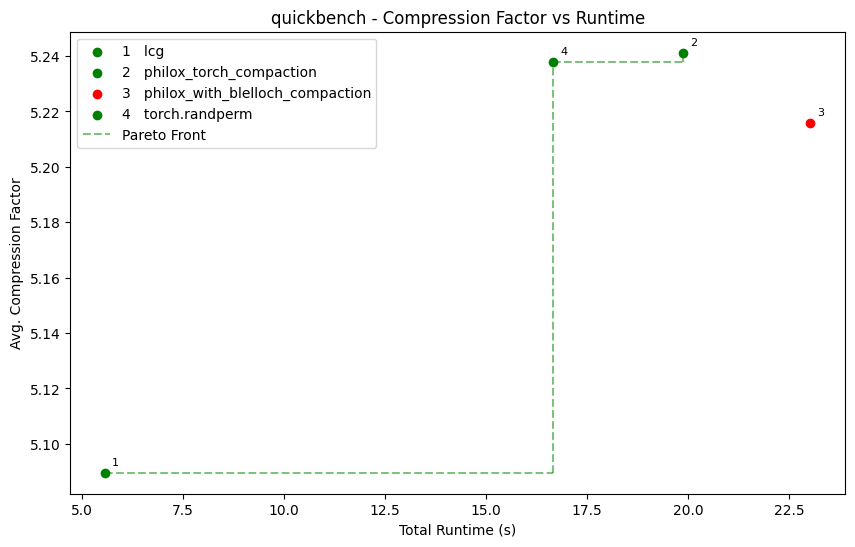

In [24]:
plot_pareto_front(**aggregate_benchmark_logs("compression_factor", ignore_keys=["gaussian_splatting", "images"]), metric_label="Compression Factor")

### Average Neighbor L2 Distance vs Runtime

#### Images + Random Data

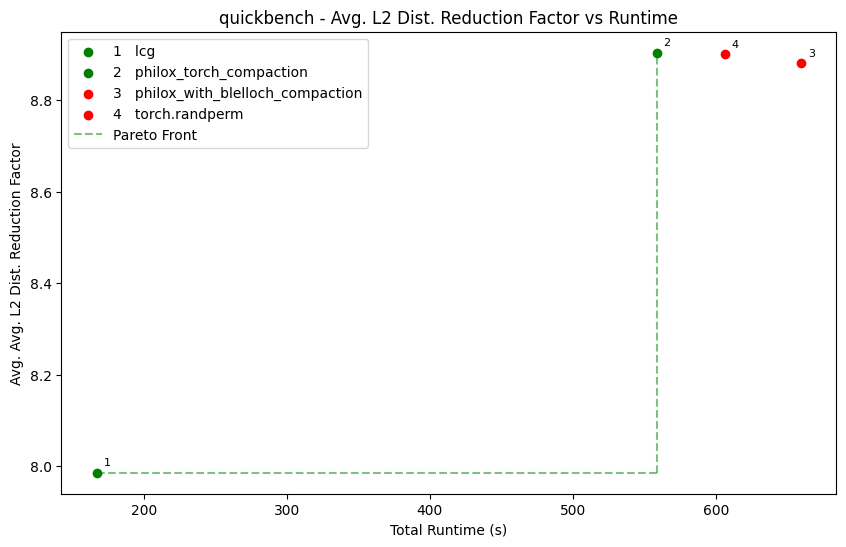

In [25]:
plot_pareto_front(**aggregate_benchmark_logs("avg_l2_dist_reduction_factor"), metric_label="Avg. L2 Dist. Reduction Factor")

#### 2D Images 

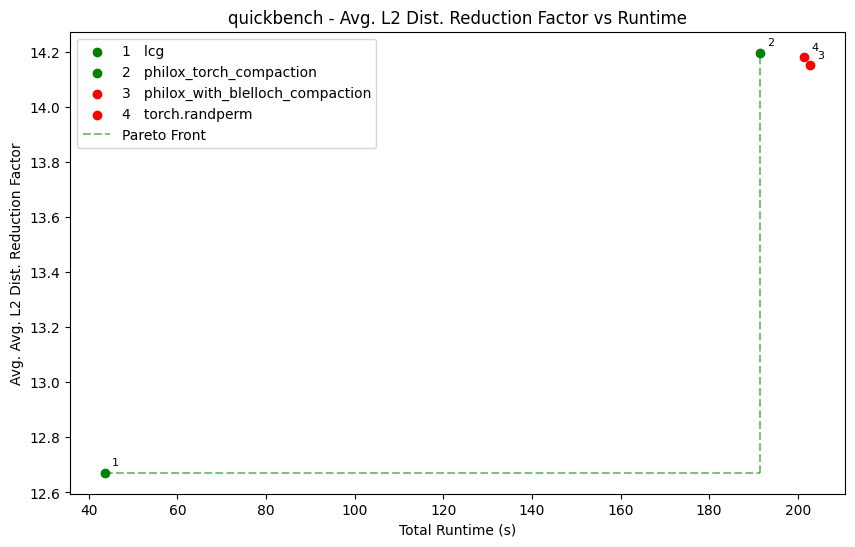

In [26]:
plot_pareto_front(**aggregate_benchmark_logs("avg_l2_dist_reduction_factor", ignore_keys=["gaussian_splatting", "random_data"]), metric_label="Avg. L2 Dist. Reduction Factor")

#### Random Data

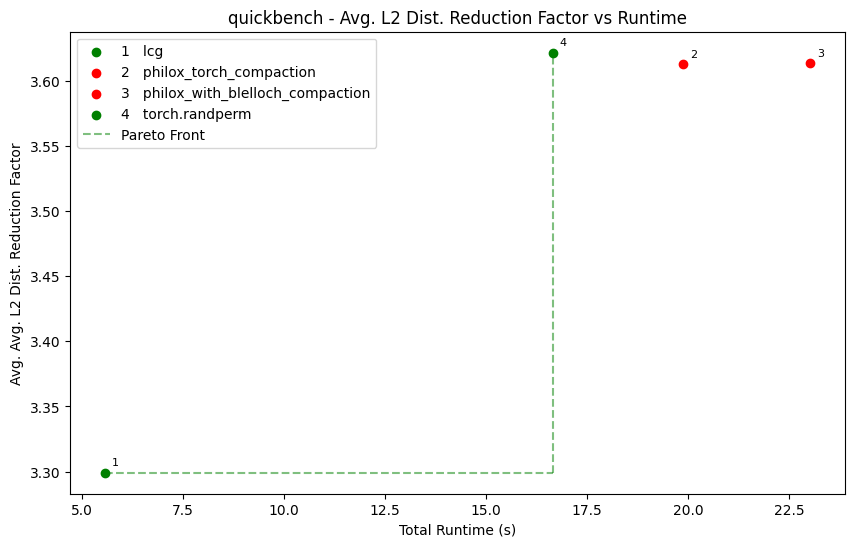

In [27]:
plot_pareto_front(**aggregate_benchmark_logs("avg_l2_dist_reduction_factor", ignore_keys=["gaussian_splatting", "images"]), metric_label="Avg. L2 Dist. Reduction Factor")